**3.2.3 문제 해결과 코드 구현**

### 경사 하강법으로 이미지 복원하기


**프로젝트 개요와 목표**

- 이미지 처리를 위해 만들어 두었던 weird_function() 함수에 실수로 버그가 들어가 100×100 픽셀의 오염된 미미지가 만들어짐
- 이 오염된 이미지와 오염되기 전 원본 이미지를 동시에 파일로 저장하려고 했으나, 모종의 이유로 원본 이미지 파일은 삭제된 상황
- weird_function()의 소스코드는 남아 있어, 오염된 이미지와 weird_function()을 활용해 원본 이미지를 복원

In [ ]:
import torch
import pickle  # 파이썬 객체를 파일 형태로 저장할 때 쓰는 라이브러리
import matplotlib.pyplot as plt

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving broken_image_t.p to broken_image_t.p


In [ ]:
# 오염된 이미지(broken_image)를 텐서 형태로 불러오기
broken_image =  torch.FloatTensor( pickle.load(open('./broken_image_t.p', 'rb'),encoding='latin1' ) )

# 오염된 이미지(broken_image)는 랭크 1의 벡터로 표현한 텐서 데이터
print(broken_image)
print("Size:", broken_image.size())
print("랭크(차원):", broken_image.ndimension())

tensor([-0.0095, -0.0004,  0.0094,  ..., -0.0014, -0.0001, -0.0036])
Size: torch.Size([10000])
랭크(차원): 1


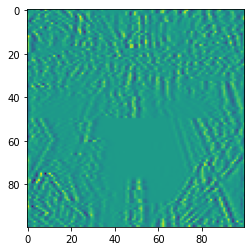

In [ ]:
# 오염된 이미지를 [100, 100] 형태로 시각화
plt.imshow(broken_image.view(100,100)) 

In [ ]:
# 이미지를 오염시키는 weird_function() 함수의 코드
def weird_function(x, n_iter=5):
    h = x    
    filt = torch.tensor([-1./3, 1./3, -1./3])
    for i in range(n_iter):
        zero_tensor = torch.tensor([1.0*0])
        h_l = torch.cat( (zero_tensor, h[:-1]), 0)
        h_r = torch.cat((h[1:], zero_tensor), 0 )
        h = filt[0] * h + filt[2] * h_l + filt[1] * h_r
        if i % 2 == 0:
            h = torch.cat( (h[h.shape[0]//2:],h[:h.shape[0]//2]), 0  )
    return h

In [ ]:
# 기존의 오염된 이미지와 가설(랜덤 텐서가 오염된 이미지)과 사이의 거리
# torch.dist()는 두 텐서 사이의 거리를 구하는 함수
def distance_loss(hypothesis, broken_image):    
    return torch.dist(hypothesis, broken_image)

In [ ]:
# 오염된 이미지 [100, 100] 형태와 동일한 랜덤 텐서 생성
random_tensor = torch.randn(10000, dtype = torch.float) # dtype = torch.float 실수 범위 내에서 랜덤 값을 뽑기 위한 옵션

In [ ]:
# lr(learning rate, 학습률) : 한 반복에서 최솟점으로 얼마나 많이 이동하는지, 학습을 얼마나 급하게 진행하는가를 정하는 매개변수
# 한 반복에서 최솟점으로 얼마나 많이 이동하는지, 학습을 얼마나 급하게 진행하는가를 정하는 매개변수
# 경사하강법 알고리즘은 기울기에 학습률을 곱해 다음 지점을 결정
# 학습률이 큰 경우 데이터가 무질서하게 이탈하며, 최솟점을 찾지 못함(최솟점을 지나침)
# 학습률이 작은 경우 학습시간이 매우 오래 걸리며, 최솟점에 도달하지 못함(학습 속도가 느려짐)
lr = 0.8

In [ ]:
for i in range(0,20000):                                         # for문을 통해 경사하강법 20000번 수행
    random_tensor.requires_grad_(True)                           # 오차함수를 random_tensor로 미분하기 위해 True 설정
    hypothesis = weird_function(random_tensor)                   # random_tensor를 weird_function() 함수에 통과시켜 가설 설정
    loss = distance_loss(hypothesis, broken_image)               # 앞에서 정의한 distance_loss() 함수에 가설과 오염된 이미지를 입력하여 오차 계산
    loss.backward()                                              # 이 후 backward() 함수를 호출해 loss를 미분
    with torch.no_grad():                                        # 직접 경사하강법을 구현하기 때문에 torch.no_grad() 함수를 이용해 for문 실행시 파이토치의 자동 기울기 계산을 비활성화 설정
        random_tensor = random_tensor - lr*random_tensor.grad     
    if i % 1000 == 0:                                            # for문이 1000번 반복될 때마다 오차를 출력
        print('Loss at {} = {}'.format(i, loss.item()))          

Loss at 0 = 12.377175331115723
Loss at 1000 = 1.083704948425293
Loss at 2000 = 0.5334588885307312
Loss at 3000 = 0.37594014406204224
Loss at 4000 = 0.2966930568218231
Loss at 5000 = 0.24751733243465424
Loss at 6000 = 0.21251222491264343
Loss at 7000 = 0.1849582940340042
Loss at 8000 = 0.16170020401477814
Loss at 9000 = 0.14112715423107147
Loss at 10000 = 0.12234684079885483
Loss at 11000 = 0.10482582449913025
Loss at 12000 = 0.0882231593132019
Loss at 13000 = 0.07231074571609497
Loss at 14000 = 0.056929461658000946
Loss at 15000 = 0.04196716099977493
Loss at 16000 = 0.027346517890691757
Loss at 17000 = 0.021157287061214447
Loss at 18000 = 0.021166130900382996
Loss at 19000 = 0.021167712286114693


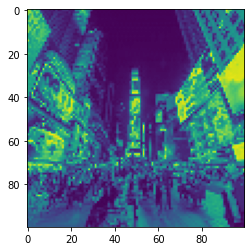

In [ ]:
# 복원된 random_tensor 이미지를 출력
plt.imshow(random_tensor.view(100,100).data)